# 2023-10-18 More about aperture photometry

In [1]:
from astropy.modeling.models import Gaussian2D
from astropy.stats import gaussian_sigma_to_fwhm

from matplotlib import pyplot as plt

import numpy as np

from photutils.profiles import RadialProfile, CurveOfGrowth

In [2]:
def image_with_pixels_labeled(image, **text_kwargs):
    image_size = image.shape[0]
    plt.imshow(image)
    plt.colorbar()
    for i in range(image_size):
        for j in range(image_size):
            plt.text(i, j, int(image[j, i]), 
                     fontweight='bold',
                     horizontalalignment='center',
                     verticalalignment='center',
                     **text_kwargs
                    )
            plt.scatter(i, j, marker='.', c='red', alpha=0.5)


In [3]:
def image_with_pixels_labeled(image, pix_precision=0, center_dots=True, ax=None, fig=None, **text_kwargs):
    image_size = image.shape[0]
    if ax is None:
        ax = plt.gca()
    if fig is not None:
        fig = plt.gcf()
    ima = ax.imshow(image)
    if fig is not None:
        fig.colorbar(ima, ax=ax)
    number_format = '{:.' + f'{pix_precision:d}' + 'f}'
    for i in range(image_size):
        for j in range(image_size):
            ax.text(i, j, number_format.format(image[j, i]), 
                     fontweight='bold',
                     horizontalalignment='center',
                     verticalalignment='center',
                     **text_kwargs
                    )
            if center_dots:
                ax.scatter(i, j, marker='.', c='red', alpha=0.5)


In [4]:
def circle(x, y, radius):
    angle = np.linspace(0, 2 * np.pi)
    return x + radius * np.cos(angle), y + radius * np.sin(angle)

In [5]:
rng = np.random.default_rng(seed=548975)

In [6]:
figure_size = (20, 20)
graph_size = (10, 10)
image_size = 25
star_center = (12, 12)
background_center = 200
sigma = 2  # Gaussian width of the star
background_image = rng.poisson(lam=background_center, size=[image_size, image_size])

In [7]:
circ = circle(*star_center, 2.1)

In [8]:

fwhm = sigma * gaussian_sigma_to_fwhm

star = Gaussian2D(amplitude=200, x_stddev=sigma, y_stddev=sigma)
grids = np.mgrid[0:image_size, 0:image_size]
star_grid = star(grids[0] - star_center[0], grids[1] - star_center[1])

In [9]:
total_image = background_image + star_grid

In [10]:
new_background_image = rng.poisson(lam=200, size=[image_size, image_size])
new_total_image = new_background_image + star_grid

In [11]:
images = dict(star_only=star_grid, star_sky=new_total_image)
radprofs = dict(star_only=RadialProfile(images['star_only'], star_center, np.arange(18)),
                star_sky=RadialProfile(images['star_sky'], star_center, np.arange(18))
               )
curgrow = dict(star_only=CurveOfGrowth(images['star_only'], star_center, np.arange(1, 19)),
               star_sky=CurveOfGrowth(images['star_sky'], star_center, np.arange(1, 19))
              )
titles = dict(star_only='STAR ONLY', star_sky='STAR + SKY')

signals = dict(
    star_only=curgrow['star_only'].profile,
    star_sky=curgrow['star_sky'].profile - background_center * curgrow['star_sky'].area
)

noises = dict(
    star_only=np.sqrt(curgrow['star_only'].profile),
    star_sky=np.sqrt(curgrow['star_sky'].profile + background_center * curgrow['star_sky'].area)
)

## Images

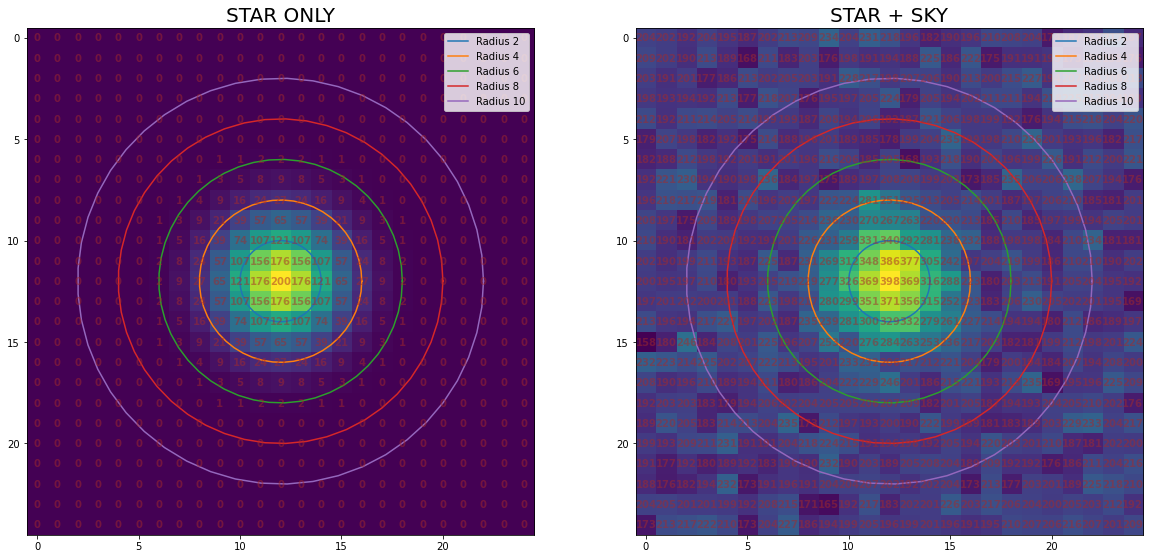

In [12]:
fig, axs = plt.subplot_mosaic([['star_only', 'star_sky']], figsize=(20, 10))

for key, ax in axs.items():
    image_with_pixels_labeled(images[key], color='brown', ax=ax, center_dots=False, alpha=0.5)
    ax.set_title(titles[key], fontsize=20)
    for i in range(5):
        radius = 2 + i * 2
        i_circ = circle(*star_center, radius)
        ax.plot(i_circ[0], i_circ[1], label=f'Radius {radius}');
    ax.legend(loc='upper right')

## Radial profiles

Text(0, 0.5, 'pixel value')

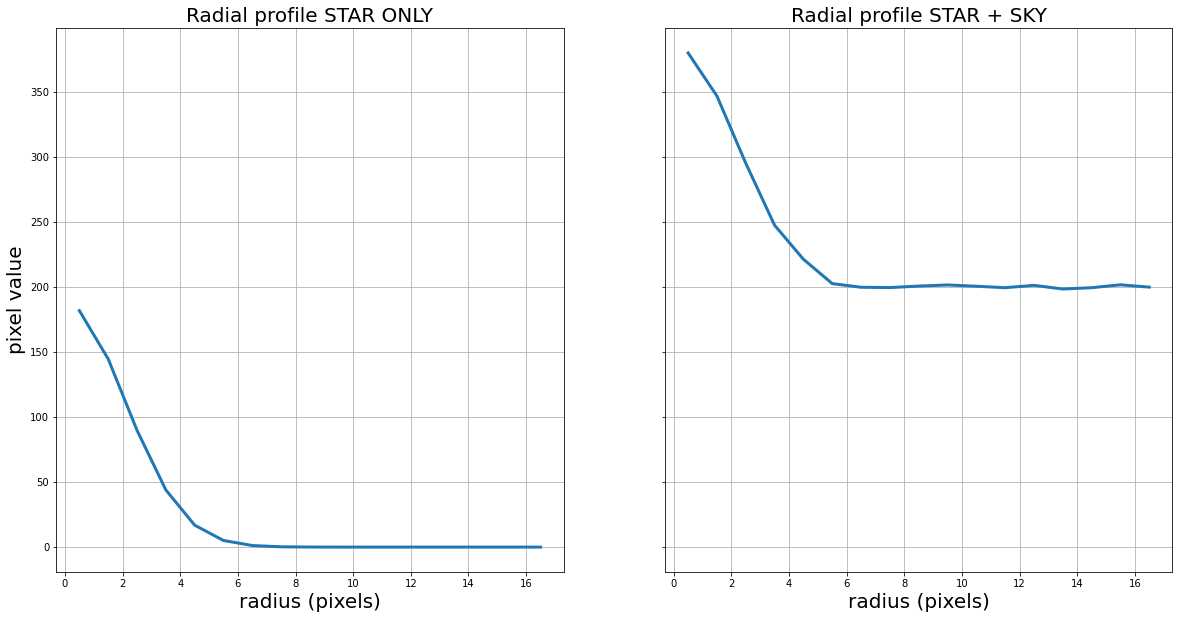

In [13]:
fig, axs = plt.subplot_mosaic([['star_only', 'star_sky']], figsize=(20, 10), sharey=True)

for key, ax in axs.items():
    rprof = radprofs[key]
    ax.plot(rprof.radius, rprof.profile, linewidth=3)
    ax.set_title(f'Radial profile {titles[key]}', fontsize=20)
    # ax.set_ylim(0, 400)
    ax.set_xlabel('radius (pixels)', fontsize=20)

    ax.grid()
axs['star_only'].set_ylabel('pixel value', fontsize=20)


## Total counts inside radius

Text(0, 0.5, 'Counts')

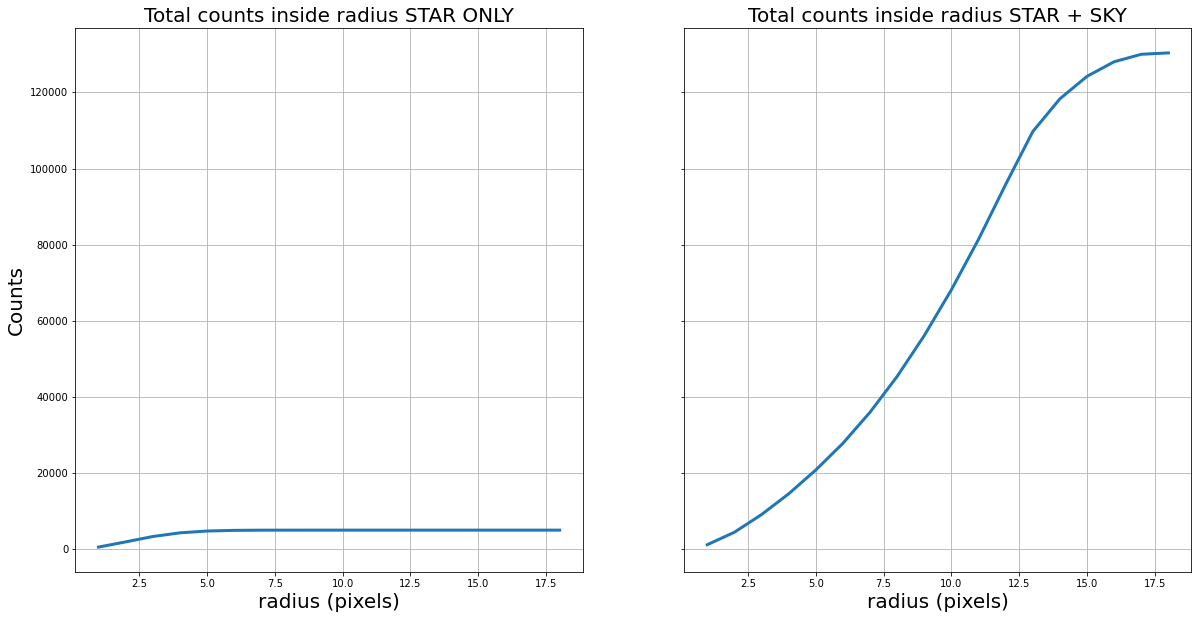

In [14]:
fig, axs = plt.subplot_mosaic([['star_only', 'star_sky']], figsize=(20, 10), sharey=True)

for key, ax in axs.items():
    cgrow = curgrow[key]
    ax.plot(cgrow.radius, cgrow.profile, linewidth=3)
    ax.set_title(f'Total counts inside radius {titles[key]}', fontsize=20)
    # ax.set_ylim(0, 400)
    ax.set_xlabel('radius (pixels)', fontsize=20)

    ax.grid()
axs['star_only'].set_ylabel('Counts', fontsize=20)


## Signal only (total minus background)

Text(0, 0.5, 'Counts')

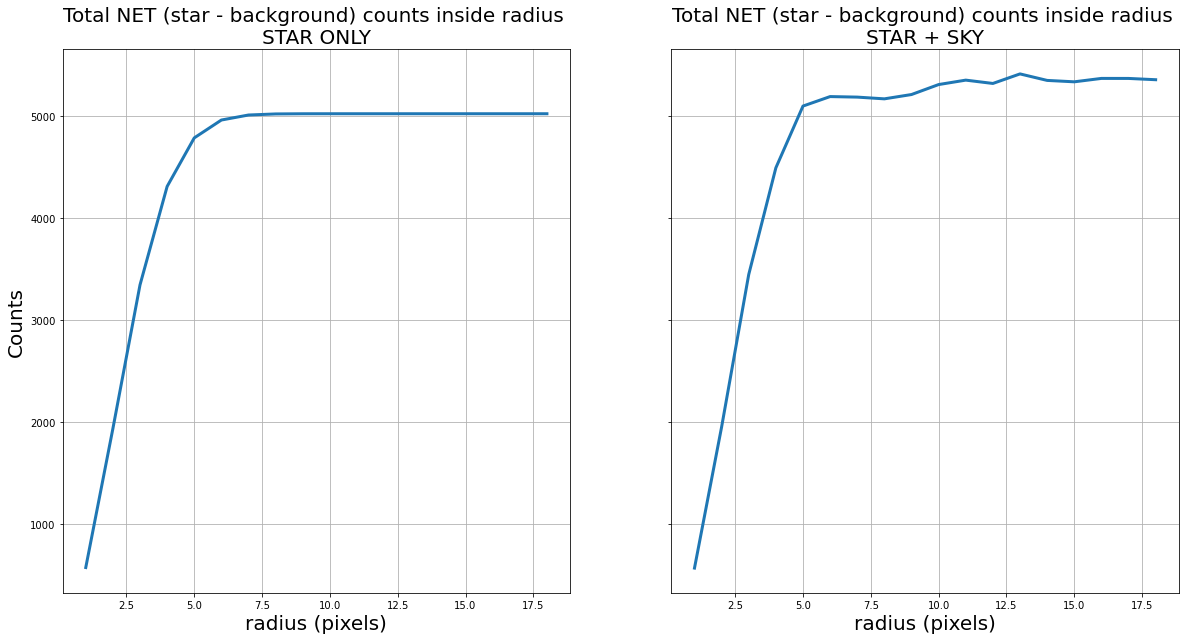

In [15]:
fig, axs = plt.subplot_mosaic([['star_only', 'star_sky']], figsize=(20, 10), sharey=True)

for key, ax in axs.items():
    cgrow = curgrow[key]
    signal = signals[key]
    ax.plot(cgrow.radius, signal, linewidth=3)
    ax.set_title(f'Total NET (star - background) counts inside radius \n{titles[key]}', fontsize=20)
    # ax.set_ylim(0, 400)
    ax.set_xlabel('radius (pixels)', fontsize=20)

    ax.grid()
axs['star_only'].set_ylabel('Counts', fontsize=20)


## Uncertainty only

Text(0, 0.5, 'Counts')

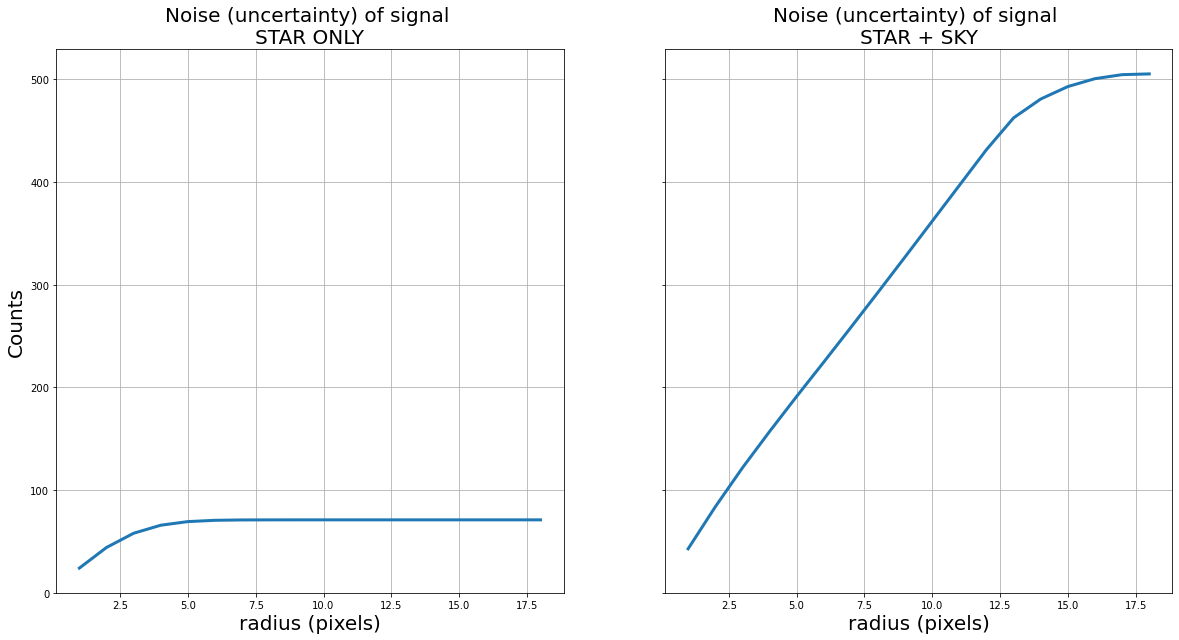

In [16]:
fig, axs = plt.subplot_mosaic([['star_only', 'star_sky']], figsize=(20, 10), sharey=True)

for key, ax in axs.items():
    cgrow = curgrow[key]
    noise = noises[key]
    ax.plot(cgrow.radius, noise, linewidth=3)
    ax.set_title(f'Noise (uncertainty) of signal \n{titles[key]}', fontsize=20)
    # ax.set_ylim(0, 400)
    ax.set_xlabel('radius (pixels)', fontsize=20)

    ax.grid()
axs['star_only'].set_ylabel('Counts', fontsize=20)

## Signal to noise ratio (signal divided by noise)

### Bigger is better

Text(0, 0.5, 'Counts')

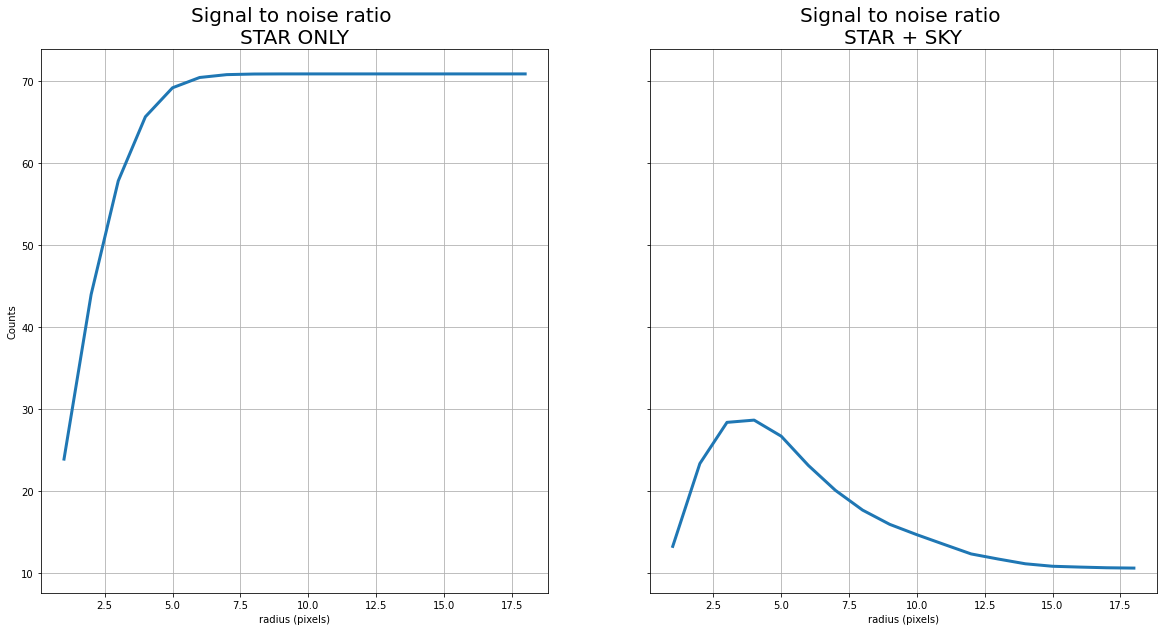

In [17]:
fig, axs = plt.subplot_mosaic([['star_only', 'star_sky']], figsize=(20, 10), sharey=True)

for key, ax in axs.items():
    cgrow = curgrow[key]
    noise = noises[key]
    signal = signals[key]
    ax.plot(cgrow.radius, signal / noise, linewidth=3)
    ax.set_title(f'Signal to noise ratio \n{titles[key]}', fontsize=20)
    # ax.set_ylim(0, 400)
    ax.set_xlabel('radius (pixels)')

    ax.grid()
axs['star_only'].set_ylabel('Counts')

## Signal to noise ratio with FWHM

Text(0, 0.5, 'Counts')

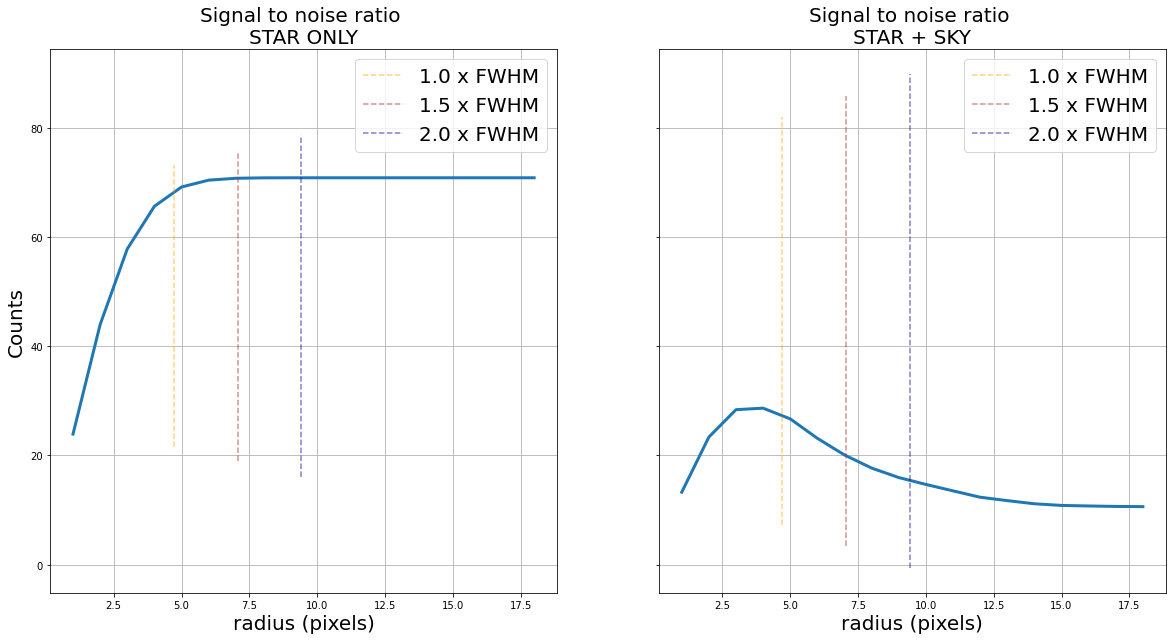

In [18]:
fig, axs = plt.subplot_mosaic([['star_only', 'star_sky']], figsize=(20, 10), sharey=True)

for key, ax in axs.items():
    cgrow = curgrow[key]
    noise = noises[key]
    signal = signals[key]
    ax.plot(cgrow.radius, signal / noise, linewidth=3)
    ax.set_title(f'Signal to noise ratio \n{titles[key]}', fontsize=20)
    # ax.set_ylim(0, 400)
    ax.set_xlabel('radius (pixels)', fontsize=20)
    for i, color in zip([1.0, 1.5, 2.0], ['orange', 'brown', 'darkblue']):
        ax.vlines(i * fwhm, *ax.get_ylim(), colors=color, alpha=0.5, label=f'{i:.1f} x FWHM', linestyle='dashed')
    ax.legend(fontsize=20)
    ax.grid()
axs['star_only'].set_ylabel('Counts', fontsize=20)

## Why is there uncertainty in the measurement of the star? 

Emission of light from the star is a random process, so our detection of that light is the detectioon of random events. Repeating the exact same measurement, even in the dieal case when there is no atmospher, no read noise, and no dark current, will give a different result each time.

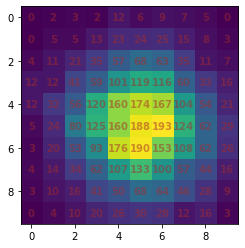

In [55]:
plt.figure()
#image_with_pixels_labeled(star_grid[7:17, 7:17], color='brown', center_dots=False, alpha=0.5)

image_with_pixels_labeled(rng.poisson(star_grid)[7:17, 7:17], color='brown', center_dots=False, alpha=0.5)


The background is also random -- here we are imagining it includes light from the sky, read noise, dark current, and any other source of uncertainty.

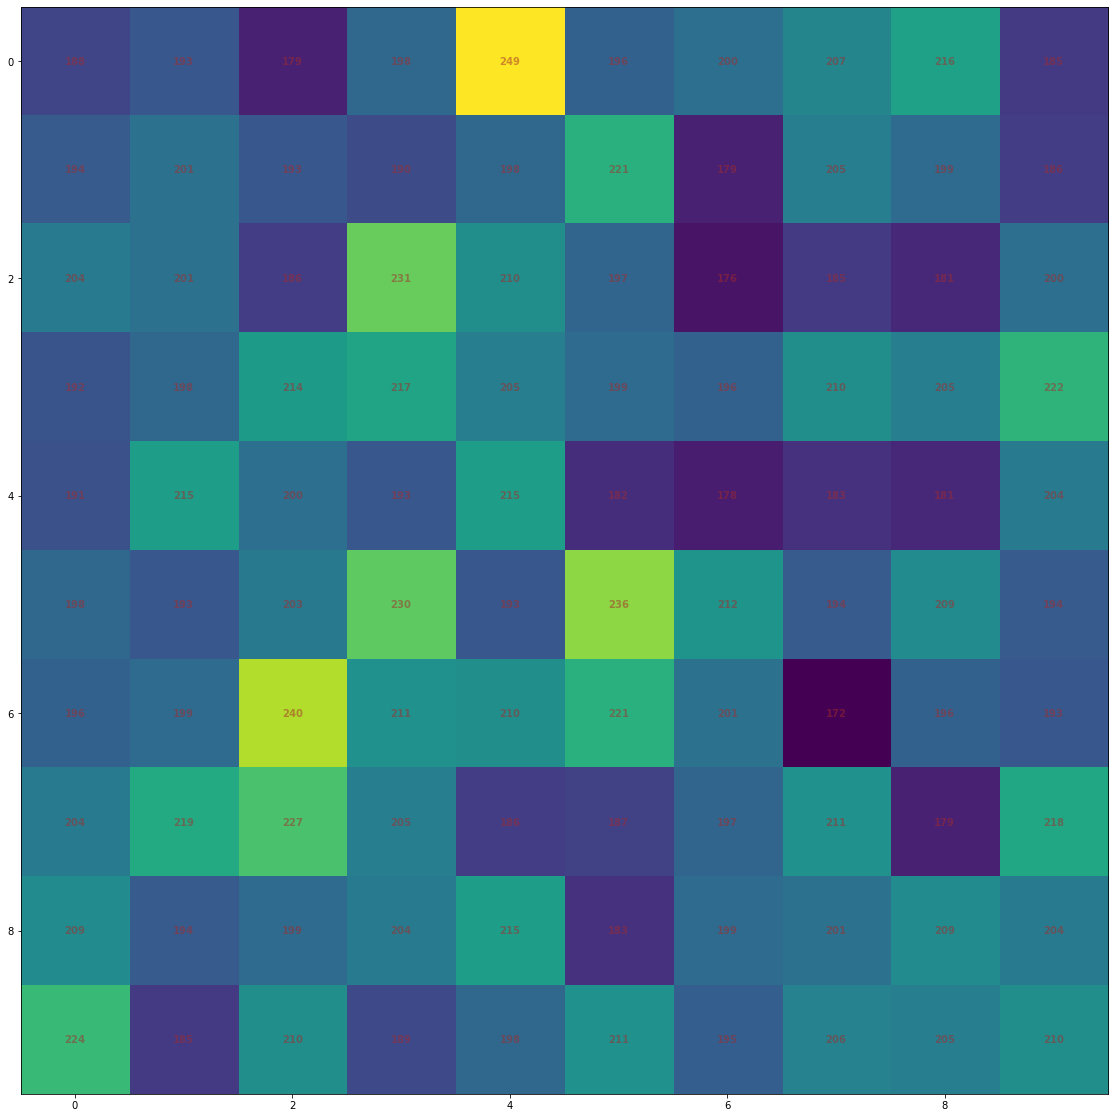

In [61]:
plt.figure(figsize=figure_size)
bkgd = rng.poisson(lam=background_center, size=[image_size, image_size])
image_with_pixels_labeled(bkgd[:10, :10], color='brown', center_dots=False, alpha=0.5)